In [2]:

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import csv

# 58 is tuesday 
# 59 is wednesday
# ...

spending_data = pd.read_csv("data/yapikredi_formatted/yapikredi_spending_data.csv")
weather_data = json.load(open("data/weather_data.json"))

In [ ]:
# outlier analysis
# get top 10 individual transactions with amounts and descriptions
top_spending = spending_data[['description', 'amount']].sort_values('amount', ascending=False)
print(top_spending.head(10))


# # Filter the data, remove the data including "V.D." (taxes), "APPLE" (outlier, phone purchase)
# for index, row in spending_data.iterrows():
#     if not ("V.D." in row['description'] or "APPLE" in row['description'] or "AJET" in row['description'] or "Spotify" in row['description']):

spending_data = spending_data[~spending_data['description'].str.contains("V.D.")]
spending_data = spending_data[~spending_data['description'].str.contains("APPLE")]
spending_data = spending_data[~spending_data['description'].str.contains("AJET")]
spending_data = spending_data[~spending_data['description'].str.contains("Spotify")]




In [ ]:
# outlier analysis

# merchant analysis
merchant_spending = spending_data.groupby('description')['amount'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
print("\nTop 10 Merchants by Total Spending:")
print(merchant_spending.head(10))



In [ ]:
# Check duplicate data (same amount, same description, same date)
duplicate_data = spending_data[spending_data.duplicated(subset=['description', 'amount', 'date'])]
print(duplicate_data)

# looks like there are some duplicate transactions, 
# some of them are installments, no need to remove them
# some of them are actual transactions (something that I bought twice back to back)



In [6]:
"""
So, I realised something here, previously I was using the `mean` method over my total spending per day on my merged data,
which is not correct, since in my merged data, the days with no spending at all are not included,
and this makes the average spending per day wrong.

for example, if my data looks like this (lets say 5 days between 1,5):
(assume all the days have the same temperature, 13)
1, X restaurant, 50
1, K restaurant, 50
2, Y restaurant, 100
5, Z restaurant, 100

mean of the total spending for the days with temp 13 should be (100+100+100)/5 = 60, right?

but when I take the mean of the merged data, I would get 100, since it would only count the days with spending, so as a solution
I will add placeholder spending with 0 amount for the days with no spending, and then take the mean of the data, this way I will get the correct mean
"""


"""
I will not add placeholder spending for the interval 164 to 168 (inclusive), 
since I was abroad in this interval and I dont have the spending data for these days (I was only using cash in Egypt).

This way the missing dates wont affect the mean. (from the same reason in above comment)
"""

for i in range(58, 164):
    if i not in spending_data['date'].values:
        new_row = pd.DataFrame({'date': [i], 'description': ['NO SPENDING'], 'amount': [0]})
        spending_data = pd.concat([spending_data, new_row], ignore_index=True)
for i in range(169, 337):
    if i not in spending_data['date'].values:
        new_row = pd.DataFrame({'date': [i], 'description': ['NO SPENDING'], 'amount': [0]})
        spending_data = pd.concat([spending_data, new_row], ignore_index=True)

# sort by date
spending_data = spending_data.sort_values('date')

# save the data back to csv
spending_data.to_csv("data/yapikredi_formatted/yapikredi_spending_data.csv", index=False)

In [7]:
spending_data = pd.read_csv("data/yapikredi_formatted/yapikredi_spending_data.csv")
weather_data = json.load(open("data/weather_data.json"))

daily_spending = spending_data.groupby('date')['amount'].sum().reset_index()

temp_data = pd.DataFrame({
    'date': weather_data['daily']['time'],
    'temp_mean': weather_data['daily']['temperature_2m_mean'],
    'rain_sum': weather_data['daily']['rain_sum'],
    'snow_sum': weather_data['daily']['snowfall_sum']
})

# merge
merged_data = pd.merge(daily_spending, temp_data, on='date')

# bin the temperature
merged_data['temp_bin'] = pd.cut(merged_data['temp_mean'], 
                                bins=range(5, 35, 5),  # Creates bins: 5-10, 10-15, ..., 30-35
                                labels=[f'{i}-{i+5}°C' for i in range(5, 30, 5)])

# ignore the days with low precipitation
merged_data['has_precipitation'] = (merged_data['rain_sum'] > 1) | (merged_data['snow_sum'] > 1)


/var/folders/fh/0nm6v2n92gldyxd0b7h3725m0000gn/T/ipykernel_12111/594254319.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_spending = merged_data.groupby('temp_bin')['amount'].mean().reset_index()


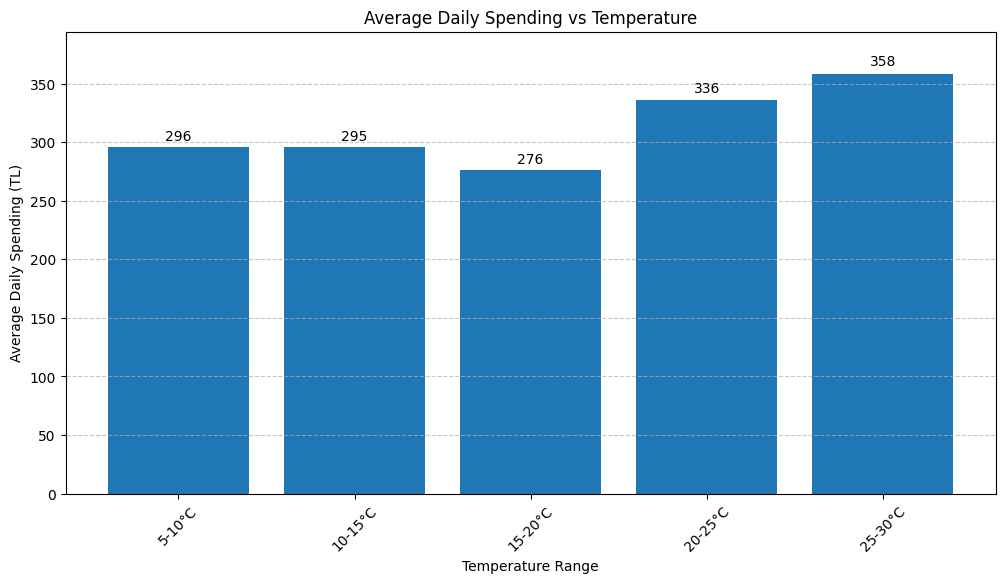

In [8]:

# avg spending per temperature bin
temp_spending = merged_data.groupby('temp_bin')['amount'].mean().reset_index()

# plot
plt.figure(figsize=(12, 6))
plt.bar(temp_spending['temp_bin'], temp_spending['amount'])
plt.title('Average Daily Spending vs Temperature')
plt.xlabel('Temperature Range')
plt.ylabel('Average Daily Spending (TL)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust label position and add padding to the top of the plot
for i, v in enumerate(temp_spending['amount']):
    plt.text(i, v * 1.02, f'{v:.0f}', ha='center')  # Changed from v + 50 to v * 1.02

# Add some padding to the top of the plot to ensure labels are visible
plt.margins(y=0.1)  # Add 10% padding to the top

plt.show()

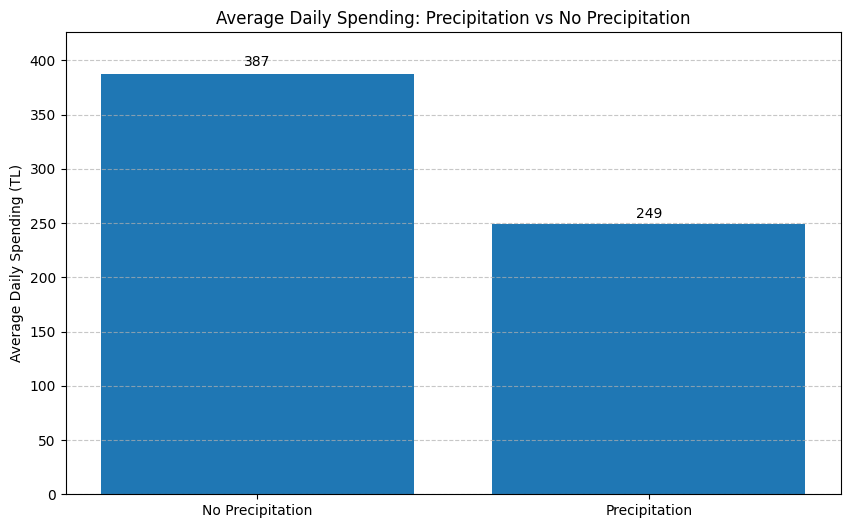


Average spending on days with vs without precipitation:
has_precipitation
False    387.080019
True     249.280152
Name: amount, dtype: float64

Percentage difference: -35.6% spending on days with precipitation


In [9]:
# calculate average spending for days with and without precipitation
precipitation_spending = merged_data.groupby('has_precipitation')['amount'].mean()

# plot
plt.figure(figsize=(10, 6))
bars = plt.bar(['No Precipitation', 'Precipitation'], 
               [precipitation_spending[False], precipitation_spending[True]])

plt.title('Average Daily Spending: Precipitation vs No Precipitation')
plt.ylabel('Average Daily Spending (TL)')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height*1.02,
             f'{height:.0f}',
             ha='center')

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add some padding to the top
plt.margins(y=0.1)



plt.show()

print("\nAverage spending on days with vs without precipitation:")
print(precipitation_spending)

pct_difference = ((precipitation_spending[True] - precipitation_spending[False]) / precipitation_spending[False]) * 100
print(f"\nPercentage difference: {pct_difference:.1f}% spending on days with precipitation")




In [10]:
# Add correlation analysis
from scipy import stats

# Calculate Pearson correlation between temperature and spending
correlation, p_value = stats.pearsonr(merged_data['temp_mean'], merged_data['amount'])
print(f"Correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

# Perform t-test for precipitation impact
precip_spending = merged_data[merged_data['has_precipitation']]['amount']
no_precip_spending = merged_data[~merged_data['has_precipitation']]['amount']
t_stat, p_value = stats.ttest_ind(precip_spending, no_precip_spending)
print(f"\nT-test results for precipitation impact:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")

Correlation coefficient: 0.149
P-value: 0.013

T-test results for precipitation impact:
t-statistic: -1.393
p-value: 0.165


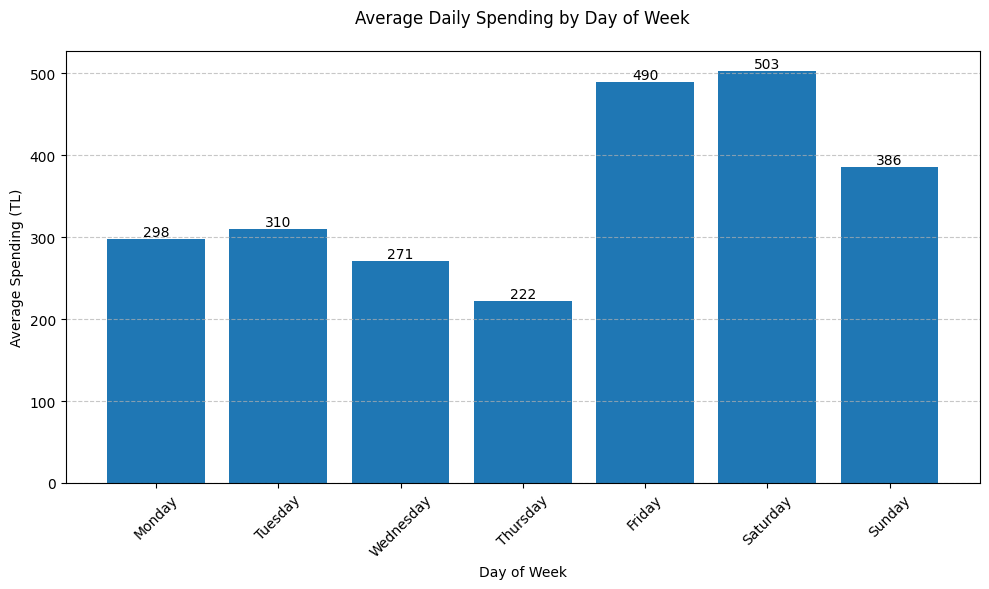

In [11]:
# Average spending for each day of the week
# Calculate average spending by day of week
# Map date numbers to days of week (58=Tuesday, etc)

day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Create day of week column
merged_data['day_of_week'] = merged_data['date'].map(lambda x: day_map[x % 7])

# Calculate average spending by day
daily_avg = merged_data.groupby('day_of_week')['amount'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(daily_avg.index, daily_avg.values)

# Customize plot
plt.title('Average Daily Spending by Day of Week', pad=20)
plt.xlabel('Day of Week')
plt.ylabel('Average Spending (TL)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}',
             ha='center', va='bottom')

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Prepare features
X = merged_data[['temp_mean', 'rain_sum', 'snow_sum']]
y = merged_data['amount']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# Feature importance
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.2f}")

R² Score: 0.019
RMSE: 459.17
temp_mean: 16.52
rain_sum: -4.51
snow_sum: -161.89


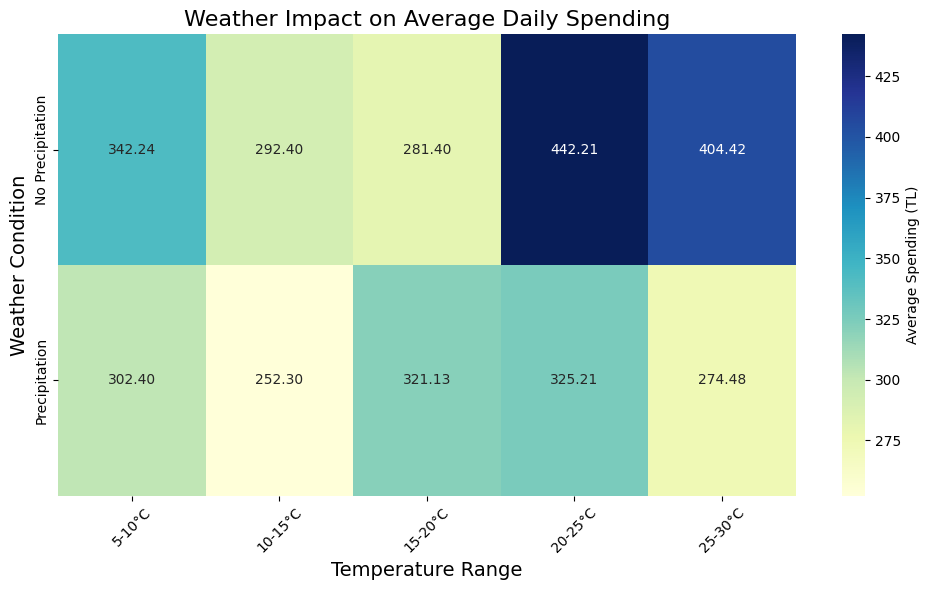

In [36]:
import seaborn as sns

merged_data['precipitation'] = merged_data['has_precipitation'].map({False: 'No Precipitation', True: 'Precipitation'})

heatmap_data = merged_data.groupby(['precipitation', 'temp_bin'])['amount'].mean().unstack()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Spending (TL)'})
plt.title('Weather Impact on Average Daily Spending', fontsize=16)
plt.xlabel('Temperature Range', fontsize=14)
plt.ylabel('Weather Condition', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the heatmap
plt.show()
